

<img src="https://neokyo.com/blog/wp-content/uploads/2019/02/ogp_new.png">

Mercari, Japan's biggest community-powered shopping app provides a marketplace for seller to sell a wide variety of products. Mercari would like to offer a pricing suggesition to its sellers. This is a tough task considering the huge amout of products solds online. Also items such as clothings have seasonal pricing trends and are higly influenced by brand names, while prices of electronics are influenced by spec of the product among other factors.

The task is to build an algorithm that automatically suggests the right product prices based on user-input text descriptions of their products, including details like product category name, brand name, and item condition.

### Dataset

The data consist of a list of product listings. These files are tab-delimited.
- train_id or test_id - the id of the listing
- name - the title of the listing. 
- item_condition_id - the condition of the items provided by the seller
- category_name - category of the listing
- brand_name
- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. 
- shipping - 1 if shipping fee is paid by seller and 0 by buyer
- item_description - the full description of the item. 

**Source:** https://www.kaggle.com/c/mercari-price-suggestion-challenge

-------------------------------------------------------------------------------------------------------------------

In [2]:
#importing packages, modules and dependencies
import sys
sys.path.append('./modules') # appending created module of useful function to the search path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import NLP_project_helper as hlp
import sklearn
import joblib

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack

from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import eli5

from functools import partial
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_union
import importlib
from unidecode import unidecode #tries to get equivalent of unicode characters in ASCII
import copy

#Settings
pd.options.mode.use_inf_as_na = True #counting empty strings as NaN

In [ ]:
#matplotlib graph setting
rcParams['figure.figsize'] = 16, 8
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler(color = ['#424424'])
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['yticks.labelsize'] = 'xx-large'

In [112]:
#importing train dataset
train = pd.read_csv("train.tsv", sep= '\t', header = 0) #loading the training data set

In [914]:
train.head(20)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


## Summary Stats

In [113]:
hlp.summary_stat(train) 

Data has 1482535 rows by 8 columns

Data type
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.482535e+06,1482535,1.482535e+06,1476208,849853,1.482535e+06,1.482535e+06,1482531
unique,NaN,1225273,NaN,1287,4809,NaN,NaN,1281426
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,2232,NaN,60177,54088,NaN,NaN,82489
mean,7.412670e+05,NaN,1.907380e+00,NaN,NaN,2.673752e+01,4.472744e-01,NaN
std,4.279711e+05,NaN,9.031586e-01,NaN,NaN,3.858607e+01,4.972124e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.706335e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.412670e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111900e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


### Observations from Summary Stats

- Data types are as expected. Features that should be strings, are, and features that should be numbers are.

- There are prices that are zero dollars. This is probably an error as there is no information about free stuffs on Mercarri.

- Also looking at the percentile we see that 75% of the price values are 29 dollars or less but the maximum price value is 2009 dollars which suggests that the price distribution is not symmetrical and it has a long tail.

- Half of Item_condition values are between 1 and 2, and the other half are from 2 to 5

- For item_description, 'No description yet', is the most common description but it does not mean a lot. Also we see that the sum of occurences of 'No description yet' and the unique values does not equal to the count of values in item_description. This means that there is at least one other description value that occurs multiple times or it could just be NaN.

We'll explore all of these further.

-----------------------------------------------------------------------------------------------------------------------

 There are 874 rows with zero price values which is not a lot in a dataset of over 1 million rows. So we'll remove them from our data set

In [114]:
train = hlp.drop_zero(train, 'price') #returns data minus rows with 0 price values


 Dropped 874 rows with zero price values


In [7]:
train[train['price']==train['price'].min()]   #min price after dropping zero values is 3 which is more reasonable

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
88,88,Misty tentacruel foil pokemon card,3,Vintage & Collectibles/Trading Cards/Animation,Pokemon,3.0,1,I have 2 available
203,203,Racerback tank top,3,"Women/Tops & Blouses/Tank, Cami",NaN,3.0,1,Tiny hole at the back barely noticeable
240,240,1998 SP Authentic Derek Jeter,2,Vintage & Collectibles/Trading Cards/Sports,MLB,3.0,1,1998 SP Authentic Derek Jeter #145
390,390,nails and nail polish set,1,Beauty/Makeup/Nails,NaN,3.0,1,Comes with both.
444,444,35 thank you stickers free shipping,1,Other/Office supplies/Shipping Supplies,NaN,3.0,1,Free shipping You'll receive 7 strips of 5 sti...
...,...,...,...,...,...,...,...,...
1482342,1482342,(6) Hawaiian Polymailers,1,Other/Office supplies/Shipping Supplies,NaN,3.0,1,"✨ Brand new, Never used ✨ The listing is still..."
1482369,1482369,2 biore pore strips,1,Beauty/Skin Care/Face,NaN,3.0,1,"2 for 3$, will ship via stamp"
1482398,1482398,Shuckle,2,Vintage & Collectibles/Trading Cards/Vintage,Pokemon,3.0,1,Near mint holo card
1482420,1482420,AE white tank,2,"Women/Tops & Blouses/Tank, Cami",American Eagle,3.0,1,NWOT size medium white tank top. Super soft an...


-----------------------------------------------------------------------------------------------------------------------
Checking for number of unique values in each feature as the summary stat above does not provide unique values for integers. There are 5 levels of item conditions as expected and 2 options for shipping

In [26]:
hlp.uniq_values_in_feature(train, list(train.columns))


There are 1481661  unique values of train_id
There are 1224596  unique values of name
There are 5  unique values of item_condition_id
There are 1288  unique values of category_name
There are 4808  unique values of brand_name
There are 827  unique values of price
There are 2  unique values of shipping
There are 1280672  unique values of item_description


-----------------------------------------------------------------------------------------------------------------------
Checking for missing values including empty strings and NaN

In [119]:
hlp.missing_count(train)

Missing Data
train_id   ---->  0 ( 0.0 % )
name   ---->  0 ( 0.0 % )
item_condition_id   ---->  0 ( 0.0 % )
category_name   ---->  6314 ( 0.4 % )
brand_name   ---->  632336 ( 42.7 % )
price   ---->  0 ( 0.0 % )
shipping   ---->  0 ( 0.0 % )
item_description   ---->  4 ( 0.0 % )


- Almost half of the items do not have a brand name and less than 1 percent do not have a category_name. 
- We noted earlier that there is at least one  other values in _item_description_ that occur multiple times which could be empty strings or NAN. From the above we know that there are very few empty strings and/or NAN.


-----------------------------------------------------------------------------------------------------------------------
### Exploring multiple occurring _item_description_ values

In [917]:
item_description_cnts = pd.DataFrame(train['item_description'].value_counts(dropna = False))
item_description_cnts.rename(columns={'item_description': 'occurence'}, inplace = True)
item_description_cnts[item_description_cnts['occurence']>20]

,occurence
No description yet,82489
New,4099
Brand new,3058
Good condition,1274
Great condition,1158
...,...
"100% Organic African Black Soap from Ghana I sell top quality African Black Soap Imported from Ghana! Don't believe me?? Compare Prices!! Helps to remove scars caused by acne.Since acne is not caused by dirt, but due to the release of excessive oils within the skin, the soap cannot remove acne. But use of African black soap helps to remove scars cause due to acne. Helps to remove skin irritations. Use of black soap helps to remove skin irritations like rashes. Suitable for all skin types. Black soap can be used for the treatment of problems on all types of skin including the dry and rough, oily and moderate skins. Beneficial for skin diseases. Black soap is very beneficial for reducing the discomforts that are associated with skin diseases like psoriasis and eczema Delays ageing on the skin. Regular use of black soap helps to remove facial lines that are mostly early signs of ageing. This black soap can be used to delay ageing of skin.",21
Brand new. Still in package.,21
Brand New Case with free shipping,21
Only worn a couple times,21


----------------------------------------------------------------------------------------------------------------------
There are 613 unique _item_description_ values that occur multiple times ranging from single word to sentences
For the long item descriptions as in the example below, we would expect the items to be very similar.
If those items are very different but described in the same way, then item_description might not be such a good predictor. Those items with the exact same long description are most likely similar itmes from the same seller 

In the example below with the item_description __"⚠️PLEASE READ⚠️ ‼️Orders will be shipped next day ‼️Delivery takes 3 to 5 business days ‼️Price is Firm •100% UV Protection (UVA and UVB) •Clear Lens Glasses •For fashion use •NON-RX (non-prescription) •Great for daily use!"__, the description is quite generic but there are some unique words like lens, glasses, that might help our model learn. 
We also see a correlation with category_names as those items are all catogerised under "Women/Women's Accessories/Sunglasse" and have no brand name

In [63]:
train[train['item_description'] == '⚠️PLEASE READ⚠️ ‼️Orders will be shipped next day ‼️Delivery takes 3 to 5 business days ‼️Price is Firm •100% UV Protection (UVA and UVB) •Clear Lens Glasses •For fashion use •NON-RX (non-prescription) •Great for daily use!' ]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
41136,41136,Clear Retro Wayfarer Glasses,1,Women/Women's Accessories/Sunglasses,NaN,7.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
43207,43207,Black Gold Clear Diamond Cut Glasses,1,Women/Women's Accessories/Sunglasses,NaN,7.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
50348,50348,Black Silver Clear Round Retro Glasses,1,Women/Women's Accessories/Sunglasses,NaN,8.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
56304,56304,Black Gold clear Round Nerd Glasses,1,Women/Women's Accessories/Sunglasses,NaN,8.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
62682,62682,Purple Mirrored Aviator Sunglasses,1,Women/Women's Accessories/Sunglasses,NaN,10.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
...,...,...,...,...,...,...,...,...
1446344,1446344,Tortoise gold Clear Clubmaste glasses,1,Women/Women's Accessories/Sunglasses,NaN,6.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
1457586,1457586,Black Gold Clear Clubmaster Glasses,1,Women/Women's Accessories/Sunglasses,NaN,9.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
1469347,1469347,Gold Octagon&Gold Aviator Clear Glasses,1,Women/Women's Accessories/Sunglasses,NaN,14.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...
1473773,1473773,Clear Frame Aviator Glasses,1,Women/Women's Accessories/Sunglasses,NaN,9.0,1,⚠️PLEASE READ⚠️ ‼️Orders will be shipped next ...


-----------------------------------------------------------------------------------------------------------------------
For the _item_description_ __"New"__ we expect the _item_condition_id_ to be mostly 1 which is what is seen below

In [90]:
train[(train['item_description'] == 'New') & (train['item_condition_id']<5) & (train['item_condition_id']>0) ]['item_condition_id'].value_counts()

1    3752
2     333
3      14
Name: item_condition_id, dtype: int64

-----------------------------------------------------------------------------------------------------------------------
### Exploring items without a category name and also Items without a brandname

As shown below, from the name columns for some of the items without a category name, it is possible to infer a category for them. For example there is an item named "ACER Laptop" and another named "3 Nora Roberts books".

Similary, items without a brand name provide some hints in the names of the items. An example is the item with the name ACER Laptop which also is not given a brandname. Another example is an item with the name Dyson hot+cool which is not given a brandname but it is clearly a Dyson brand. Also we see the items without a given brandname but the brand is mentioined in the item description.


In [921]:
train_no_cat = train[train['category_name'].isna()]
train_no_cat

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
122,122,Bundle,3,NaN,NaN,59.0,0,Sizes and info of clothes can be found on thei...
155,155,3 Nora Roberts Books,3,NaN,NaN,10.0,1,For aferg16.
258,258,ACER Laptop,5,NaN,NaN,14.0,0,"Powers on, no screen display, no external dama..."
984,984,AUTHENTIC BRWN MICHAEL KORS MAKEUP STAIN,4,NaN,Michael Kors,18.0,0,No description yet
1185,1185,Teenage Mutant Ninja Turtle Van/ Extras,3,NaN,Nickelodeon,9.0,0,"Teenage Mutant Ninja Turtle Van, April O'Neil ..."
...,...,...,...,...,...,...,...,...
1481249,1481249,Only For Erin. Do Not Buy,3,NaN,NaN,31.0,0,No description yet
1481750,1481750,American Eagle Jeggings,2,NaN,American Eagle,17.0,0,Worn a couple of time Size 4
1482252,1482252,Bundle For All Honey :),3,NaN,NaN,40.0,0,No description yet
1482443,1482443,HOLD 14g Purple Prong Nipple Bars Rings,1,NaN,NaN,22.0,1,14g Purple Prong Set Nipple Bars Rings [surgic...


In [920]:
train_no_brandname = train[train['brand_name'].isna()]
train_no_brandname

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...
...,...,...,...,...,...,...,...,...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women/Tops & Blouses/T-Shirts,NaN,12.0,0,"Great Harry Potter Shirt! ""Hogwarts, School of..."
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women/Tops & Blouses/Blouse,NaN,10.0,1,Brand new black and white ribbed mock neck bod...
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


-----------------------------------------------------------------------------------------------------------------------
#### Replacing Empty Strings and NaN
Some machine learning algorithms such as Linear regression can not process NaN. The code below is to replace any NaN and missing values and then recheck


In [120]:
values = {'category_name': 'unknown', 'brand_name': 'not provided', 'item_description': 'No description yet'}
train.fillna(value = values, inplace = True)
hlp.missing_count(train)

Missing Data
train_id   ---->  0 ( 0.0 % )
name   ---->  0 ( 0.0 % )
item_condition_id   ---->  0 ( 0.0 % )
category_name   ---->  0 ( 0.0 % )
brand_name   ---->  0 ( 0.0 % )
price   ---->  0 ( 0.0 % )
shipping   ---->  0 ( 0.0 % )
item_description   ---->  0 ( 0.0 % )


In [121]:
joblib.dump(train, 'train_checkpoint1')

['train_checkpoint1']

-----------------------------------------------------------------------------------------------------------------------
#### Converting/Removing Non ASCII characters and making all characters uniform 
There are some Non-ASCII characters such as 'ʜᴀᴠᴇ', 'ғʀᴇᴇ', 'ᴀɴʏ', 'ᴘʟᴇᴀsᴇ', 'ᴛᴏ', and symbols in the data. Although some can be pronounced in English, we would not want to have for example 'HAVE' and 'ʜᴀᴠᴇ' as two separte tokens. 

Using the Unidecode library we are going to attempt to convert the unicode characters not in ASCII into ASCII characters. It does this cleverly through transliteration and the ones that cannot be ASCII encoded are ignored. For example:

unidecode('ʜᴀᴠᴇ')
>'HAVE'


In [134]:
#First line converts all object type columns into ascii characters and second line checks if it is done properly
train = conv_to_ascii(train)
hlp.check_non_ascii(x)  #returns no error which means conversion was successful

In [136]:
joblib.dump(train, "train_non_ascii")

['train_non_ascii']

For uniformity and to aid processing all characters are converted to lowercase

In [137]:
#first line converts all object type columns to lowercase and second line verifies that they are all in lower case
train = hlp.case_selection(train, case = 'lower') 
hlp.case_check(train)

Checking if case in feature values are uniform
name ---> All lowercase
category_name ---> All lowercase
brand_name ---> All lowercase
item_description ---> All lowercase



,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,mlb cincinnati reds t shirt size xl,3,men/tops/t-shirts,not provided,10.0,1,no description yet
1,1,razer blackwidow chroma keyboard,3,electronics/computers & tablets/components & p...,razer,52.0,0,this keyboard is in great condition and works ...
2,2,ava-viv blouse,1,women/tops & blouses/blouse,target,10.0,1,adorable top with a hint of lace and a key hol...
3,3,leather horse statues,1,home/home decor/home decor accents,not provided,35.0,1,new with tags. leather horses. retail for [rm]...
4,4,24k gold plated rose,1,women/jewelry/necklaces,not provided,44.0,0,complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,women/dresses/mid-calf,free people,20.0,1,"lace, says size small but fits medium perfectl..."
1482531,1482531,little mermaid handmade dress,2,kids/girls 2t-5t/dresses,disney,14.0,0,little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,sports & outdoors/exercise/fitness accessories,not provided,12.0,0,"used once or twice, still in great shape."
1482533,1482533,world markets lanterns,3,home/home decor/home decor accents,not provided,45.0,1,there is 2 of each one that you see! so 2 red ...


In [138]:
joblib.dump(train, "train_lowercase")

['train_lowercase']

## EDA & Visualizations

Earlier, it was mentioned that 75% of the price values are less than $25 and so the distribution is expected to have a long tail. We see this in the graph below on the left. The data is heavily skewed and might not work particularly well with linear regression models. Hence we apply a log transformation to make the distribution as normal as possible. More so, the required scoring method for the model is root mean squared log error (RMSLE).

The log transformed data is shown on the right

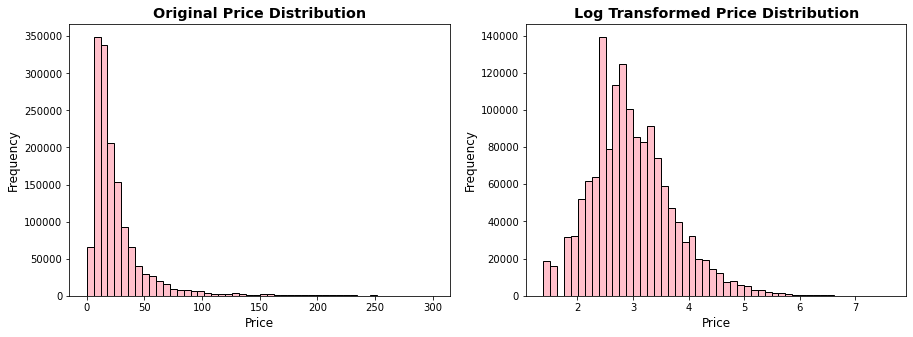

In [139]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(train['price'], bins = 50, range = [0, 300], linewidth=1, edgecolor="black", facecolor = 'pink')
ax[0].set_xlabel('Price', fontsize = 'large')
ax[0].set_ylabel('Frequency', fontsize = 'large')
ax[0].set_title('Original Price Distribution', fontsize = 'x-large', fontweight = 'bold')

ax[1].hist(np.log1p(train['price']), bins = 50,  linewidth=1, edgecolor="black", facecolor = 'pink')
ax[1].set_xlabel('Price', fontsize = 'large')
ax[1].set_ylabel('Frequency', fontsize = 'large')
ax[1].set_title('Log Transformed Price Distribution', fontsize = 'x-large', fontweight = 'bold')

plt.show()

In [141]:
train['log_price'] = np.log1p(train['price']) #creating a new column for log transformed price

In [142]:
joblib.dump(train, 'train_logprice')

['train_logprice']

-----------------------------------------------------------------------------------------------------------------------
The top ten categories for the listed items are shown below. We see that eight of the top ten are feminine product if   beauty items are categorized as feminine

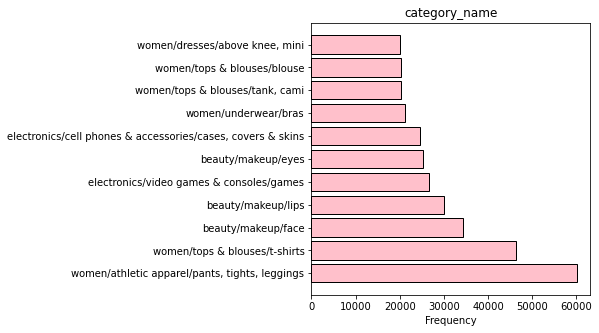

In [209]:
hlp.cat_chart(train, 'category_name')

----------------------------------------------------------------------------------------------------------------------
Below, the _category_name_ is broken into 5 subcategories with the majority of the data falling into the first three categories

In [144]:
subcat = (train['category_name']).str.split("/", n = 0, expand = True)
subcat

,0,1,2,3,4
0,men,tops,t-shirts,None,None
1,electronics,computers & tablets,components & parts,None,None
2,women,tops & blouses,blouse,None,None
3,home,home decor,home decor accents,None,None
4,women,jewelry,necklaces,None,None
...,...,...,...,...,...
1482530,women,dresses,mid-calf,None,None
1482531,kids,girls 2t-5t,dresses,None,None
1482532,sports & outdoors,exercise,fitness accessories,None,None
1482533,home,home decor,home decor accents,None,None


In [145]:
#appending the subcategories into the training data
subcategory = ['maincat', 'subcat1', 'subcat2', 'subcat3', 'subcat4']
for i in range (0,5):
    train[subcategory[i]] = subcat[i]

In [146]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,maincat,subcat1,subcat2,subcat3,subcat4
0,0,mlb cincinnati reds t shirt size xl,3,men/tops/t-shirts,not provided,10.0,1,no description yet,2.397895,men,tops,t-shirts,None,None
1,1,razer blackwidow chroma keyboard,3,electronics/computers & tablets/components & p...,razer,52.0,0,this keyboard is in great condition and works ...,3.970292,electronics,computers & tablets,components & parts,None,None
2,2,ava-viv blouse,1,women/tops & blouses/blouse,target,10.0,1,adorable top with a hint of lace and a key hol...,2.397895,women,tops & blouses,blouse,None,None
3,3,leather horse statues,1,home/home decor/home decor accents,not provided,35.0,1,new with tags. leather horses. retail for [rm]...,3.583519,home,home decor,home decor accents,None,None
4,4,24k gold plated rose,1,women/jewelry/necklaces,not provided,44.0,0,complete with certificate of authenticity,3.806662,women,jewelry,necklaces,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,women/dresses/mid-calf,free people,20.0,1,"lace, says size small but fits medium perfectl...",3.044522,women,dresses,mid-calf,None,None
1482531,1482531,little mermaid handmade dress,2,kids/girls 2t-5t/dresses,disney,14.0,0,little mermaid handmade dress never worn size 2t,2.708050,kids,girls 2t-5t,dresses,None,None
1482532,1482532,21 day fix containers and eating plan,2,sports & outdoors/exercise/fitness accessories,not provided,12.0,0,"used once or twice, still in great shape.",2.564949,sports & outdoors,exercise,fitness accessories,None,None
1482533,1482533,world markets lanterns,3,home/home decor/home decor accents,not provided,45.0,1,there is 2 of each one that you see! so 2 red ...,3.828641,home,home decor,home decor accents,None,None


In [147]:
#replacing all the None values in the subcategories with 'unknown'
values = {'subcat1': 'unknown', 'subcat2': 'unknown', 'subcat3': 'unknown', 'subcat4': 'unknown'}
train.fillna(value = values, inplace = True)

In [148]:
joblib.dump(train, 'train_subcat')

['train_subcat']

-----------------------------------------------------------------------------------------------------------------------
Chart below show that Women and beauty product make up more than half of the listed items

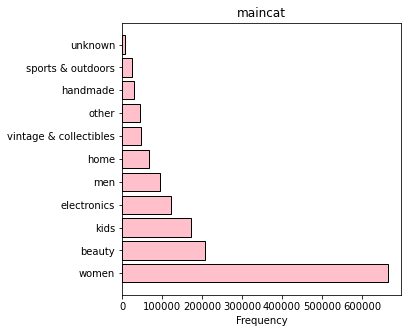

In [208]:
hlp.cat_chart(train, 'maincat')

----------------------------------------------------------------------------------------------------------------------
Most items are rated from excellent/new to average conditions (1-3) 

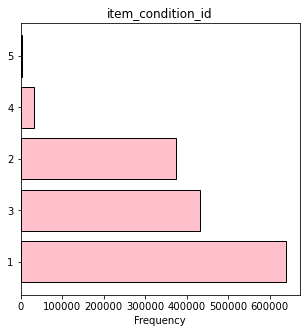

In [211]:
hlp.cat_chart(train, 'item_condition_id')

-----------------------------------------------------------------------------------------------------------------------
Grouping the data by the main categories, we see that not only one or a few categories contribute to the skewness of the price dristribution, but rather all. The largest range from the min to the 75 percentile price in any category is $37 ( men's category), but the max price in each category is tens to a hundred of magnitude of this value

In [149]:
#Price distribution of main categories
maincat_group = train.groupby('maincat').describe()
maincat_group['price']

,count,mean,std,min,25%,50%,75%,max
maincat,,,,,,,,
beauty,207725.0,19.681290,21.360937,3.0,10.0,15.0,24.0,2000.0
electronics,122632.0,35.190558,65.430780,3.0,9.0,15.0,31.0,1909.0
handmade,30835.0,18.160694,27.760091,3.0,6.0,12.0,20.0,1750.0
home,67831.0,24.551068,24.416986,3.0,12.0,18.0,29.0,848.0
kids,171555.0,20.658439,22.732427,3.0,10.0,14.0,24.0,809.0
men,93609.0,34.734940,41.244610,3.0,14.0,21.0,40.0,1309.0
other,45329.0,20.819917,29.851479,3.0,9.0,14.0,23.0,1400.0
sports & outdoors,25322.0,25.552385,29.305013,3.0,11.0,16.0,28.0,915.0
unknown,6314.0,25.446943,34.130040,3.0,10.0,16.5,28.0,1000.0


Exploring the beauty category further, we see that the makeup subcategory  has items a lot more expensive than any other beauty subcategory. 
When we breakdown the makeup category we see 4 subcategories that have items that are relatively more expensive compared with items in the other six categories under makeup

We could use this information to engineer new features in the data set such as min price, max price, mean price for each category and subcategory and see how it impacts our model's performance

In [159]:
#grouping by beauty subcategories to see their price distribution
beauty_group_subcat1 = train[train['maincat'] == 'beauty'].groupby('subcat1').describe()
beauty_group_subcat1['price']

,count,mean,std,min,25%,50%,75%,max
subcat1,,,,,,,,
bath & body,7753.0,19.096995,18.150859,3.0,9.0,15.0,23.0,565.0
fragrance,24278.0,23.816748,21.205083,3.0,12.0,18.0,30.0,569.0
hair care,7767.0,19.382130,16.217179,3.0,10.0,15.0,23.0,239.0
makeup,124568.0,18.694576,20.854124,3.0,10.0,15.0,22.0,2000.0
other,489.0,22.952965,32.192490,3.0,8.0,14.0,25.0,259.0
skin care,29822.0,20.508718,24.363565,3.0,10.0,14.0,24.0,894.0
tools & accessories,13048.0,19.918148,22.014307,3.0,9.0,14.0,22.0,375.0


In [160]:
#showing price distribution of the categories under makeup which is under beauty
beauty_group_subcat2 = train[(train['maincat'] == 'beauty') & (train['subcat1'] == 'makeup')].groupby('subcat2').describe()
beauty_group_subcat2['price']

,count,mean,std,min,25%,50%,75%,max
subcat2,,,,,,,,
body,748.0,11.237968,12.702109,3.0,6.0,8.0,12.0,225.0
brushes & applicators,2531.0,13.088305,11.701889,3.0,7.0,10.0,16.0,271.0
eyes,25200.0,14.630635,11.842546,3.0,8.0,12.0,18.0,406.0
face,34320.0,18.478963,20.572976,3.0,10.0,15.0,23.0,2000.0
lips,29901.0,18.526421,18.972208,3.0,10.0,14.0,22.0,980.0
makeup palettes,19091.0,25.577497,27.496253,3.0,15.0,22.0,30.0,1515.0
makeup remover,445.0,14.044944,9.870912,3.0,9.0,12.0,16.0,101.0
makeup sets,6172.0,24.047310,34.029309,3.0,11.0,16.0,25.0,1015.0
nails,6044.0,14.033422,15.483435,3.0,7.0,10.0,16.0,306.0


----------------------------------------------------------------------------------------------------------------------
Analysing the items price based on shipping, we see that when the buyer pays shipping fees, the items are on average more expensive than when the seller pays the shipping. All things being equal we would expect on average that the items whose shipping fees are paid by the seller to cost more. Looking at the percentiles it appears that items whose shipping fees are paid for by the buyer are costlier on average

In [161]:
#  1- seller paying  0-buyer paying
train.groupby('shipping').describe()['price']  

,count,mean,std,min,25%,50%,75%,max
shipping,,,,,,,,
0,818876.0,30.132333,39.541581,5.5,13.0,20.0,33.0,2009.0
1,662785.0,22.578452,36.961295,3.0,9.0,14.0,25.0,2000.0


--------------------------------------------------------------------------------------------------------------------
Top 10 Brands by frequency

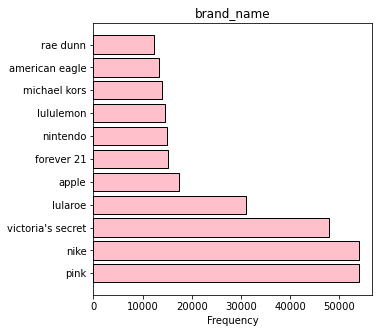

In [212]:
hlp.cat_chart(train[train['brand_name'] != 'not provided'], 'brand_name') #filtering out items without a brand name

----------------------------------------------------------------------------------------------------------------------
Top 20 Brands by Average price

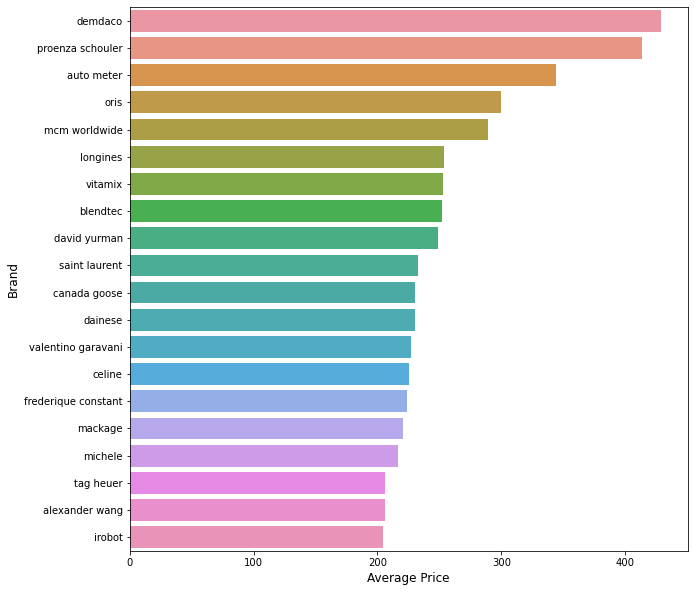

In [146]:
brand_name_items = train[train['brand_name'] != 'not provided']
brand_name_group = train.groupby('brand_name').describe()['price']
brand_name_group = brand_name_group.sort_values('mean', ascending = False)[:20]

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.barplot(y = brand_name_group.reset_index()['brand_name'], x = brand_name_group.reset_index()['mean'] )
ax.set_xlabel('Average Price', size = 'large')
ax.set_ylabel('Brand', size = 'large')

plt.show()

-----------------------------------------------------------------------------------------------------------------------
The most expensive item with no brand_name provided is a diamond engagement ring

In [167]:
unbranded_items = train[train['brand_name'] == 'not provided']
unbranded_items[unbranded_items['price'] == unbranded_items.price.max()]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,maincat,subcat1,subcat2,subcat3,subcat4
1445348,1445348,vs2/i 1ct diamond engagement ring,2,women/jewelry/rings,not provided,2000.0,1,absolutely stunning diamond engagement ring pu...,7.601402,women,jewelry,rings,unknown,unknown


In [213]:
joblib.dump(train, 'train_txt_prc_start')

['train_txt_prc_start']

In [3]:
train = joblib.load('train_txt_prc_start')

In [4]:
train

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,maincat,subcat1,subcat2,subcat3,subcat4
0,0,mlb cincinnati reds t shirt size xl,3,men/tops/t-shirts,not provided,10.0,1,no description yet,2.397895,men,tops,t-shirts,unknown,unknown
1,1,razer blackwidow chroma keyboard,3,electronics/computers & tablets/components & p...,razer,52.0,0,this keyboard is in great condition and works ...,3.970292,electronics,computers & tablets,components & parts,unknown,unknown
2,2,ava-viv blouse,1,women/tops & blouses/blouse,target,10.0,1,adorable top with a hint of lace and a key hol...,2.397895,women,tops & blouses,blouse,unknown,unknown
3,3,leather horse statues,1,home/home decor/home decor accents,not provided,35.0,1,new with tags. leather horses. retail for [rm]...,3.583519,home,home decor,home decor accents,unknown,unknown
4,4,24k gold plated rose,1,women/jewelry/necklaces,not provided,44.0,0,complete with certificate of authenticity,3.806662,women,jewelry,necklaces,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,women/dresses/mid-calf,free people,20.0,1,"lace, says size small but fits medium perfectl...",3.044522,women,dresses,mid-calf,unknown,unknown
1482531,1482531,little mermaid handmade dress,2,kids/girls 2t-5t/dresses,disney,14.0,0,little mermaid handmade dress never worn size 2t,2.708050,kids,girls 2t-5t,dresses,unknown,unknown
1482532,1482532,21 day fix containers and eating plan,2,sports & outdoors/exercise/fitness accessories,not provided,12.0,0,"used once or twice, still in great shape.",2.564949,sports & outdoors,exercise,fitness accessories,unknown,unknown
1482533,1482533,world markets lanterns,3,home/home decor/home decor accents,not provided,45.0,1,there is 2 of each one that you see! so 2 red ...,3.828641,home,home decor,home decor accents,unknown,unknown


## Text Preprocessing 

Most of the machine learning algorithms can not process text. We need to encode our text data numerically for machine learning models to work with. We would be applying techniques such as tokenization (spliting text into bag of words) and vectorization using countvectorization, label binarizer, one hot encoding and TFIDF

It is important that our model learns signal and not noise from text. Stopwords such as that, they, would've generally represents noise and would be removed from our model. We will use the stopwords from nlkt library because the default 'english' stopword in sklearn has some problems. For example the stopword does not contain 've', so after tokenizing a word like 'would've', the 've' would be ratained in the transformed text. Also stopsword that are transformed as a result of transformation like stemming or lemmaization might not be caught because the preprocessor step using sklearn's CountVectorizer or TfidfVectorizer is done before tokenization, but the stopwords are only removed after tokenization. Hence we create our custom preprocessor function than can will first remove stop words and then stem or lemmatize what is left of the text 

We will also stem or lemmatize item_description and see the model's performance

In this section we remove punctuation and symbols (e.g '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), stopwords(words such ) that would only present noise in our model. We also stem words which is essentially removing prefixes and suffixes from words, but does not necessarily result in the root word. For example 'ponies' stems 'poni'.

In [1]:
def preprocessor (doc, stem_lem = None, rm_stp_wrd = 'yes' ):
    
    '''fuction to stem or lemmatize a string or remove stopwords
        parameters:
            doc: string
            stem: choose either 'stem'(for stemming) or 'lemmatize'(for lemmatizing). Default is None
            rm_stp_wrd: string. variable to remove stopwords or not. Default removes stopwords'''
    
    snowball = SnowballStemmer(language = 'english')
    portstem = PorterStemmer()
    wn = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    if stem_lem == 'stem' and rm_stp_wrd == 'yes':
        doc = ' '.join([ snowball.stem(i) for i in doc.split(' ') if i not in stop_words])
    if stem_lem == 'lemmatize' and rm_stp_wrd == 'yes':
         doc = ' '.join([ wn.lemmatize(i) for i in doc.split(' ')if i not in stop_words])
    if stem_lem == 'stem' and rm_stp_wrd != 'yes':
        doc = ' '.join([ snowball.stem(i) for i in doc.split(' ')])
    if stem_lem == 'lemmatize' and rm_stp_wrd != 'yes':
         doc = ' '.join([ wn.lemmatize(i) for i in doc.split(' ')])
    if stem_lem == None and rm_stp_wrd == 'yes':
        doc = ' '.join([ i for i in doc.split(' ')if i not in stop_words])
        
    return doc


# BASELINE MODELS

Using Ridge regression, we are going to try different combinations of TFIDF and countvectorizer on the features and preprocessing(stopwords, stemming, n-grams) and see which gives the best cross validation score

In [8]:
# cross validation function
def cross_val(model,data,feature,target):
    cval= cross_val_score(model, data[feature], data[target], scoring="neg_root_mean_squared_error", cv = 5, verbose = 1) 
    return cval

### Ridge and Countvectorizer 

In [333]:
#feature: name
# Prepocessing: stopwords removed, stemming applied
# vectorizer: Countvectorizer
vec = CountVectorizer(preprocessor = partial(preprocessor, stem_lem = 'stem', rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'name'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

The cross validation RMSLE is:  [0.54951784 0.54961326 0.55076629 0.54993931 0.54972354]
RMSLE | CountVectorizer | name  ----> 0.5499120489219627


In [334]:
#feature: name
# Prepocessing: stopwords removed
# vectorizer: Countvectorizer
vec = CountVectorizer(preprocessor = partial(preprocessor, rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'name'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

The cross validation RMSLE is:  [0.54347476 0.54367712 0.54452842 0.54421288 0.54359169]
RMSLE | CountVectorizer | name  ----> 0.5438969746138573


In [339]:
#feature: name
# Preprocessing: stopwords removed, stemming applied, ngram range (1 to 2)
# vectorizer: Countvectorizer
vec = CountVectorizer(ngram_range=(1, 2), preprocessor = partial(preprocessor, rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'name'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

The cross validation RMSLE is:  [0.50664872 0.50708293 0.50769682 0.50722291 0.50701981]
RMSLE | CountVectorizer | name  ----> 0.5071342374219732


In [264]:
#feature: item_description
# Preprocessing: stopwords removed, stemming applied
# vectorizer: Countvectorizer
vec = CountVectorizer(preprocessor = partial(preprocessor, stem_lem = 'stem', rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'item_description'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

/home/tb23unix/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/home/tb23unix/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/home/tb23unix/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words

The cross validation RMSLE is:  [0.63204281 0.6313576  0.63187516 0.63208883 0.63167405]
RMSLE | CountVectorizer | item_description  ----> 0.6318076886019708


In [340]:
#feature: item_description
# Preprocessing: stopwords removed, ngram range (1 to 2)
# vectorizer: Countvectorizer
vec = CountVectorizer(ngram_range=(1, 2), preprocessor = partial(preprocessor,  rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'item_description'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

The cross validation RMSLE is:  [0.64946867 0.65170614 0.65169127 0.65156424 0.65057147]
RMSLE | CountVectorizer | item_description  ----> 0.6510003587895588


In [335]:
#feature: item_description
# Preprocessing: stopwords removed
# vectorizer: Countvectorizer
vec = CountVectorizer(preprocessor = partial(preprocessor, rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'item_description'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

The cross validation RMSLE is:  [0.63096509 0.62765735 0.62872159 0.62961203 0.62904619]
RMSLE | CountVectorizer | item_description  ----> 0.6292004486589833


In [337]:
#feature: brand_name
# Preprocessing:  ngram range (1 to 2)
# vectorizer: Countvectorizer
vec = CountVectorizer(ngram_range=(1, 2))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'brand_name'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

The cross validation RMSLE is:  [0.65333572 0.6532739  0.65550871 0.65381541 0.65403631]
RMSLE | CountVectorizer | brand_name  ----> 0.6539940090846944


From the models above, we see that 'name' feature gives the best cross validation score when used with countvectorizer with stopwords removed and ngrams range of 1 to 2 

----------------------------------------------------------------------------------------------------------------------

### Ridge and TFIDF 

In [9]:
%%time
#feature: name
# Preprocessing: stopwords removed, 
# vectorizer: TFIDFvectorizer
vec = TfidfVectorizer(preprocessor = partial(preprocessor, rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'name'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The cross validation RMSLE is:  [0.54334115 0.54363912 0.54367859 0.54337711 0.54326962]
RMSLE | CountVectorizer | name  ----> 0.5434611173944522
CPU times: user 12min 15s, sys: 33.4 s, total: 12min 49s
Wall time: 11min 23s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.4min finished


In [344]:
%%time
#feature: name
# Preprocessing: stopwords removed, ngrams range 1 to 2
# vectorizer: TFIDFvectorizer
vec = TfidfVectorizer(ngram_range=(1, 2), preprocessor = partial(preprocessor, rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'name'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................... , score=-0.503, total= 3.1min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV] ................................... , score=-0.504, total= 3.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.5min remaining:    0.0s


[CV] ................................... , score=-0.504, total= 3.4min
[CV]  ................................................................
[CV] ................................... , score=-0.504, total= 3.5min
[CV]  ................................................................
[CV] ................................... , score=-0.504, total= 3.4min
The cross validation RMSLE is:  [0.50331056 0.50411032 0.50372397 0.50378845 0.50352712]
RMSLE | CountVectorizer | name  ----> 0.5036920847344852
CPU times: user 20min 39s, sys: 58.3 s, total: 21min 37s
Wall time: 16min 50s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 16.8min finished


In [343]:
%%time
#feature: item_description
# Preprocessing: stopwords removed, stemming applied 
# vectorizer: TFIDFvectorizer

vec = TfidfVectorizer(preprocessor = partial(preprocessor, stem_lem = 'stem', rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'item_description'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................... , score=-0.601, total= 7.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.8min remaining:    0.0s


[CV] ................................... , score=-0.600, total= 7.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 15.1min remaining:    0.0s


[CV] ................................... , score=-0.602, total= 7.4min
[CV]  ................................................................
[CV] ................................... , score=-0.601, total= 7.2min
[CV]  ................................................................
[CV] ................................... , score=-0.600, total= 7.4min
The cross validation RMSLE is:  [0.60057444 0.59950895 0.60158793 0.60119059 0.59986416]
RMSLE | CountVectorizer | item_description  ----> 0.6005452165729125
CPU times: user 41min 21s, sys: 56.3 s, total: 42min 17s
Wall time: 37min 11s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 37.2min finished


In [15]:
%%time
#feature: item_description
# Preprocessing: stopwords removed
# vectorizer: TFIDFvectorizer

vec = TfidfVectorizer(preprocessor = partial(preprocessor, rm_stp_wrd = 'yes'))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'item_description'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The cross validation RMSLE is:  [0.59530199 0.59401456 0.59604863 0.59593473 0.59429773]
RMSLE | CountVectorizer | item_description  ----> 0.5951195280807504
CPU times: user 24min 5s, sys: 57.6 s, total: 25min 3s
Wall time: 19min 44s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.7min finished


In [347]:
%%time
#feature: item_description
# Preprocessing: ngrams range 1 to 2
# vectorizer: TFIDFvectorizer
vec = TfidfVectorizer(ngram_range=(1, 2))
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
#pipe.fit(train[feature], train[target])

data = train
feature = 'brand_name'
target = 'log_price'
cv_base = cross_val(pipe, data, feature, target )

print("The cross validation RMSLE is: ",  str(-cv_base))
a = print('RMSLE | CountVectorizer |', feature,' ---->' , np.mean(-cv_base) )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The cross validation RMSLE is:  [0.65328271 0.65321819 0.65543979 0.65373383 0.65402531]
RMSLE | CountVectorizer | brand_name  ----> 0.6539399680465927
CPU times: user 1min 31s, sys: 2.02 s, total: 1min 33s
Wall time: 47 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.0s finished


----------------------------------------------------------------------------------------------------------------

From the TFIDF models above, the 'name' feature also provided the best score in cross validation score when used with stopwords removed and ngrams range of 1 to 2.

Overall, the TFIDF models performed better and the TFIDF model with 'name' feature preprocessed to remove stop words and using ngrams range 1 to 2 had the best average cross validation RMSLE score of 0.503

### ELI5
Using the ELI5 package we are going to explore what the best model from above as learnt and see if it makes sense by looking at the weight assinged to words 

In [10]:
##recreating best baseline model in a pipeline 
data = train
feature = 'name'
target = 'log_price'
vec = TfidfVectorizer(ngram_range=(1, 2), preprocessor = partial(preprocessor, rm_stp_wrd = 'yes') )
ridg = Ridge(random_state=42)
pipe = make_pipeline(vec, ridg)
pipe.fit(train[feature], train[target])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 preprocessor=functools.partial(<function preprocessor at 0x7f2db7228790>, rm_stp_wrd='yes'))),
                ('ridge', Ridge(random_state=42))])

In [11]:
##showing the words with the biggest influence 
eli5.explain_weights(pipe, top = 50, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+4.075,dy
+3.402,dyson
+3.256,128gb
+3.227,5mm bracelet
+3.110,jovani
+3.096,14k
+3.070,inr
+3.056,beach bunny
+3.052,bose
+3.051,nikon


We see words like dyson, jovani, 256gb, 500gb as some of the top words which seems to be reasonable as a predictor of pricier items

---------------------------------------------------------------------------------------------------------------------

## Feature Transformation

We would like to train a model with a combination of or all of the features in the data set. 
To do this we need to preprocess and transform each feature and concactenate 

In [48]:
# class to process data set features before tokenizing using countvectorizer or tfidf
class Processor():
    def __init__(self, feature):
        self.feature = feature
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        if x[self.feature].dtype != 'object':
            z = x[self.feature].astype('str')
            return z
        else:
            return x[self.feature]

In [30]:
#creating a pipeline for processing and transforming each feature and then concatenating using feature union

pipe_name = make_pipeline(Processor('name'), TfidfVectorizer(ngram_range=(1, 2), preprocessor = partial(preprocessor, rm_stp_wrd = 'yes')))
pipe_brand_name = make_pipeline(Processor('brand_name'), CountVectorizer(ngram_range = (1,2)))
pipe_item_description = make_pipeline(Processor('item_description'),  TfidfVectorizer(preprocessor = partial(preprocessor, rm_stp_wrd = 'yes')))
pipe_item_condition_id = make_pipeline(Processor('item_condition_id'), CountVectorizer(analyzer = 'char'))
pipe_shipping = make_pipeline(Processor('shipping'), CountVectorizer(analyzer = 'char'))
pipe_maincat = make_pipeline(Processor('maincat'), CountVectorizer())
pipe_subcat1 = make_pipeline(Processor('subcat1'), CountVectorizer())
pipe_subcat2 = make_pipeline(Processor('subcat2'), CountVectorizer())
pipe_subcat3 = make_pipeline(Processor('subcat3'), CountVectorizer())
pipe_subcat4 = make_pipeline(Processor('subcat4'), CountVectorizer())


pipe_union = make_union(pipe_name,pipe_brand_name, pipe_item_description,pipe_item_condition_id,
                                pipe_shipping, pipe_maincat, pipe_subcat1, pipe_subcat2, pipe_subcat3, pipe_subcat4)

In [20]:
#fitting  the data into the pipeline to create vector matrix of features
vectorized_features = pipe_union.fit_transform(train)

In [24]:
joblib.dump(vectorized_features, 'vectorized_features')

['vectorized_features']

In [4]:
vectorized_features = joblib.load('vectorized_features')

In [50]:
def vec_feature_list(pipe_union):
    ''' Provides the list of words tokenized to form the csr matrix after transformation using countvectorizer, tfidfvectorizer, etc
    pipe_union: union of transformation pipelines on data columns
    need to call fit_transform on pipe_union(union of feature pipelines) before running function'''
    z = []
    for pipeline in pipe_union.transformer_list:
        x = pipeline[1].steps[1][1].get_feature_names()
        z = z + x
    return z

In [52]:
##vec_feature_list(vectorized_features)

In [6]:
def cross_val(model,x,y):
    cval= cross_val_score(model, x, y, scoring="neg_root_mean_squared_error", cv = 5) 
    return cval

## Ridge Model

In [72]:
x_train, x_test, y_train, y_test = train_test_split(vectorized_features, train['log_price'], test_size =0.2, random_state  = 1 )

In [39]:
#GridSearch Ridge to select optimum aplha value
%time
x = vectorized_features
y = train['log_price']
ridg_model = Ridge(random_state=42)
param_grid = {'alpha' : [ 1.2, 0.8, 1]}
ridg_grid = GridSearchCV(ridg_model, param_grid, scoring = "neg_root_mean_squared_error", verbose = 2, n_jobs = 1, cv=5, return_train_score = True)

ridg_grid.fit(x, y)



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=1.2 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ alpha=1.2, total= 7.9min
[CV] alpha=1.2 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min remaining:    0.0s


[CV] ........................................ alpha=1.2, total= 9.0min
[CV] alpha=1.2 .......................................................
[CV] ........................................ alpha=1.2, total=10.1min
[CV] alpha=1.2 .......................................................
[CV] ........................................ alpha=1.2, total= 9.3min
[CV] alpha=1.2 .......................................................
[CV] ........................................ alpha=1.2, total=10.4min
[CV] alpha=0.8 .......................................................
[CV] ........................................ alpha=0.8, total=10.3min
[CV] alpha=0.8 .......................................................
[CV] ........................................ alpha=0.8, total=10.2min
[CV] alpha=0.8 .......................................................
[CV] ........................................ alpha=0.8, total= 9.9min
[CV] alpha=0.8 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 139.6min finished


GridSearchCV(cv=5, estimator=Ridge(random_state=42), n_jobs=1,
             param_grid={'alpha': [1.2, 0.8, 1]}, return_train_score=True,
             scoring='neg_root_mean_squared_error', verbose=2)

In [40]:
ridg_grid.best_score_

-0.44657043576423233

In [64]:
#joblib.dump(ridg_grid, 'ridg_grid')

['ridg_grid']

In [53]:
ridg_grid = joblib.load('ridg_grid')

In [67]:
ridg = ridg_grid.best_estimator_

In [82]:
ridg = Ridge(alpha=1.5, random_state=42)

In [83]:
ridg.fit(x_train, y_train)

Ridge(alpha=1.5, random_state=42)

In [84]:
ridg_y_pred_train = ridg.predict(x_train)
ridg_y_pred_test = ridg.predict(x_test)

In [77]:
#comparing prediction and actual side by side
#z = pd.DataFrame(({'y_train':y_train, 'ridg_y_pred_train': ridg_y_pred_train})) 
#w = z.apply(lambda x: np.expm1(x)) #expm1 is inverse of log1p
#z

In [86]:
print('train_RMSLE_ridge---> ', metrics.mean_squared_error(y_train, ridg_y_pred_train, squared = False) )
print('test_RMSLE_ridge---> ', metrics.mean_squared_error(y_test, ridg_y_pred_test, squared = False) )

train_RMSLE_ridge--->  0.3543527132082144
test_RMSLE_ridge--->  0.44512906121464146


In [50]:
metrics.mean_squared_error(y, ridg_y_pred, squared = False) 

0.33954881738459597

/home/tb23unix/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tb23unix/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_price', ylabel='Density'>

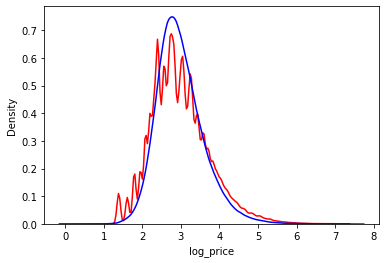

In [91]:
ax = sns.distplot(y_train, hist = False, label = "Actual", color= 'red')
sns.distplot(ridg_y_pred_train, hist = False, ax = ax, label = "prediction", color = 'blue')


/home/tb23unix/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tb23unix/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_price', ylabel='Density'>

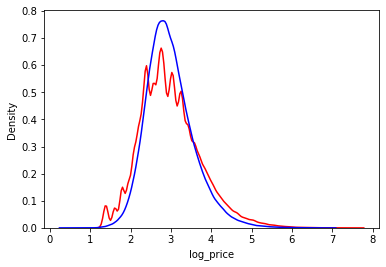

In [92]:
ax1 = sns.distplot(y_test, hist = False, label = "Actual", color= 'red')
sns.distplot(ridg_y_pred_test, hist = False, ax = ax1, label = "prediction", color = 'blue')

## LGBM Model

In [6]:
def cross_val(model,x,y):
    cval= cross_val_score(model, x, y, scoring="neg_root_mean_squared_error", cv = 5) 
    return cval

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(vectorized_features, train['log_price'], test_size =0.2, random_state  = 1 )

In [ ]:
##takes forever
lgb_model = lgb.LGBMRegressor(random_state = 95)
param_grid = {'max_depth': [10, 15, 20],
              'num_leaves': [31, 20],
             'learning_rate': [0.1, 0.5,0.7],
              'n_estimators': [100],
              'min_child_samples': [8,5, 3]
             }
lgb_grid = RandomizedSearchCV(lgb_model, param_grid, scoring = "neg_root_mean_squared_error", verbose = 7, n_jobs = 1, pre_dispatch= 1, return_train_score = True)

lgb_grid.fit(x, y)

#best_estimator = lgb_grid.best_params_
#best_estimator

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] num_leaves=31, n_estimators=100, min_child_samples=3, max_depth=15, learning_rate=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [6]:
## Base line LGBM without hyperparamenter tuning

%time

lgb_model = lgb.LGBMRegressor(num_leaves= 10,
 n_estimators= 100,
 min_child_samples= 5,
 max_depth =15,
 learning_rate = 0.7, random_state = 95, n_jobs = 2, verbose = 3)

x = vectorized_features
y = train['log_price']
val_scores = cross_val(lgb_model, x, y )

print("The cross validation RMSLE is: ",  str(-val_scores))
print('RMSLE ---->' , np.mean(-val_scores))

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.34 µs
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999885
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999855
[LightGBM] [Debug] init for col-wise cost 8436.666358 seconds, init for row-wise cost 6464.648447 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 8438.194571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 1507023
[LightGBM] [Info] Number of data points in the train set: 1185328, number of used features: 358719
[LightGBM] [Info] Start training from score 2.980782
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightG

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 7
[LightGBM] [Debug] Traine

In [63]:
## Base line LGBM without hyperparamenter tuning

%time

lgb_model = lgb.LGBMRegressor(num_leaves= 20,
 n_estimators= 100,
 min_child_samples= 5,
 max_depth =15,
 learning_rate = 0.5, random_state = 95)

x = vectorized_features
y = train['log_price']
val_scores = cross_val(lgb_model, x, y )

print("The cross validation RMSLE is: ",  str(-val_scores))
print('RMSLE ---->' , np.mean(-val_scores))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
The cross validation RMSLE is:  [0.49801471 0.49831429 0.49823277 0.49746831 0.49672426]
RMSLE ----> 0.49775086879390174


In [8]:
%%time

lgb_model = lgb.LGBMRegressor(num_leaves= 20,
 n_estimators= 100,
 min_child_samples= 7,
 max_depth =15,
 learning_rate = 0.5, random_state = 95, n_jobs = -1, verbose = 2)

x = vectorized_features
y = train['log_price']

lgb_model.fit(x,y)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999887
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999854
[LightGBM] [Debug] init for col-wise cost 3049.007474 seconds, init for row-wise cost 2671.026316 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2672.258011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504477
[LightGBM] [Info] Number of data points in the train set: 1481661, number of used features: 357674
[LightGBM] [Info] Start training from score 2.980816
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 20 a

LGBMRegressor(learning_rate=0.5, max_depth=15, min_child_samples=7,
              num_leaves=20, random_state=95, verbose=2)

In [19]:
%%time

lgb_model = lgb.LGBMRegressor(num_leaves= 20,
 n_estimators= 100,
 min_child_samples= 3,
 max_depth =15,
 learning_rate = 0.5, random_state = 95, n_jobs = -1, verbose = 2)

x = vectorized_features
y = train['log_price']

lgb_model.fit(x,y)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999887
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999854
[LightGBM] [Debug] init for col-wise cost 2732.260192 seconds, init for row-wise cost 2751.789340 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2792.722700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504477
[LightGBM] [Info] Number of data points in the train set: 1481661, number of used features: 357674
[LightGBM] [Info] Start training from score 2.980816
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 20 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 20 a

LGBMRegressor(learning_rate=0.5, max_depth=15, min_child_samples=3,
              num_leaves=20, random_state=95, verbose=2)

In [24]:
##best-so_far
%%time 

lgb_model = lgb.LGBMRegressor(num_leaves= 30,
 n_estimators= 100,
 min_child_samples= 5,
 max_depth =30,reg_alpha = 1.1,
 learning_rate = 0.7, random_state = 95, n_jobs = -1, verbose = 2)

x = vectorized_features
y = train['log_price']

lgb_model.fit(x,y)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999887
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999854
[LightGBM] [Debug] init for col-wise cost 2811.241280 seconds, init for row-wise cost 2833.856583 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2834.825745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504477
[LightGBM] [Info] Number of data points in the train set: 1481661, number of used features: 357674
[LightGBM] [Info] Start training from score 2.980816
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 30

LGBMRegressor(learning_rate=0.7, max_depth=30, min_child_samples=5,
              num_leaves=30, random_state=95, reg_alpha=1.1, verbose=2)

In [38]:
%%time 


lgb_model = lgb.LGBMRegressor(num_leaves= 30,
 n_estimators= 100,
 min_child_samples= 5,
 max_depth =30,reg_alpha = 1.5,
 learning_rate = 0.7, random_state = 95, n_jobs = -1, verbose = 2)

x = vectorized_features
y = train['log_price']

lgb_model.fit(x,y)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999887
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999854
[LightGBM] [Debug] init for col-wise cost 2646.566791 seconds, init for row-wise cost 2677.809702 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2678.818424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1504477
[LightGBM] [Info] Number of data points in the train set: 1481661, number of used features: 357674
[LightGBM] [Info] Start training from score 2.980816
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 30

LGBMRegressor(learning_rate=0.7, max_depth=30, min_child_samples=5,
              num_leaves=30, random_state=95, reg_alpha=1.5, verbose=2)

In [23]:
joblib.dump(lgb_model, 'lgb_model')

['lgb_model']

In [31]:
lgb_model = joblib.load('lgb_model')

In [39]:
lgb_model

LGBMRegressor(learning_rate=0.7, max_depth=30, min_child_samples=5,
              num_leaves=30, random_state=95, reg_alpha=1.5, verbose=2)

In [40]:
lgb_y_pred = lgb_model.predict(x)

In [55]:
z = pd.DataFrame(({'y':y, 'lgb_y_pred': lgb_y_pred})) 
w = z.apply(lambda x: np.expm1(x)) #expm1 is inverse of log1p
w

,y,lgb_y_pred
0,10.0,9.906542
1,52.0,38.851046
2,10.0,10.931734
3,35.0,14.333646
4,44.0,20.071292
...,...,...
1482530,20.0,18.279108
1482531,14.0,14.172381
1482532,12.0,16.087344
1482533,45.0,10.457346


In [42]:
metrics.mean_squared_error(y, lgb_y_pred, squared = False) 

0.4760288847950107

In [43]:
metrics.mean_squared_error(y, lgb_y_pred, squared = True) 

0.22660349915918157

/home/tb23unix/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/tb23unix/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_price', ylabel='Density'>

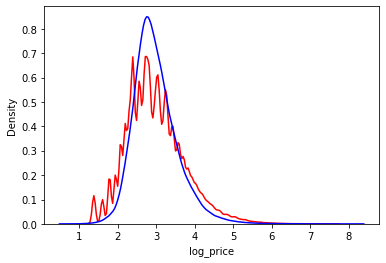

In [30]:
ax = sns.distplot(y, hist = False, label = "Actual", color= 'red')
sns.distplot(lgb_y_pred, hist = False, ax = ax, label = "prediction", color = 'blue')

## FUTURE WORk

Groupby first subcategories, Look at percentile, you'll see that most categories have outliers and 0 to 75% is quite tight. this can help with prediction.

Also check those items that are outliers and and you might be able to categorise them as well

##ELI5

In [10]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])